# Universidad Nacional de Córdoba
# DIPLODATOS - Facultad de Matemática, Astronomía, Física y Computación

## Trabajo Práctico Número 1 (Analisis del archivo exercise_1.py)

Autores: 
* Diaz Cobos Facundo
* Epifanio Luis
* Gonzalez Leonardo David
* Gualpa Mariano Martín




# 1. Consigna del Ejercicio 1.

1. Procesar el conjunto de datos para obtener una representación TfIDf de cada review.
  * Hint: User el código de *Aprendizaje Supervisado*
  * Hint: El método de fit de Keras crea internamente un conjunto de datos de validación, por lo que no tienen que preocuparse por eso.

2. Construir un pipeline de clasificación con un modelo Keras NLP.

3. Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los modelos en el conjunto de test.

4. Reportar los hyperparámetros y resultados de todos los modelos entrenados. Para esto, pueden utilizar una notebook o un archivo (pdf|md). Dentro de este reporte tiene que describir:
  * Hyperparámetros con los que procesaron el dataset: tamaño del vocabulario, normalizaciones, etc.
  * Las decisiones tomadas al construir cada modelo: regularización, dropout, número y tamaño de las capas, optimizador.
  * Proceso de entrenamiento: división del train/test, tamaño del batch, número de épocas, métricas de evaluación. Seleccione los mejores hiperparámetros en función de su rendimiento. El proceso de entrenamiento debería ser el mismo para todos los modelos.
  * (Punto estrella) Analizar si el clasificador está haciendo overfitting. Esto se puede determinar a partir del resultado del método fit.

# 2. Desarrollo.

## 2.1. Carga de Librerías y Funciones 

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
# To make it work on Colab.
#!wget --continue https://github.com/david-gonzalez/aprendizaje-profundo/raw/master/dataset/txt_sentoken.zip
#!mkdir dataset && mv txt_sentoken.zip ./dataset
#!cd dataset && unzip txt_sentoken.zip

### Instalar librerías de nltk por única vez.
Descomentar y correr solo si no se tienen instaladas.

In [3]:
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

### Importar paquetes.

In [4]:
from IPython.display import display, HTML
from itertools import repeat

from keras import regularizers, layers, optimizers, losses, metrics
from keras.initializers import RandomNormal
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Dense, GRU, Embedding
from keras.models import Sequential
from keras.optimizers import Adam

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import WordPunctTokenizer

from printutils import print_message, print_new_process, print_end

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from tensorflow.python.client import device_lib
from tensorflow.python.keras.utils import np_utils   # for tf 1.3.1
from tensorflow.test import gpu_device_name

import argparse
import datetime
import numpy  as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import string

/Users/mgualpa/anaconda3/envs/DataScience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
def read_args():
    parser = argparse.ArgumentParser(description='Exercise 1')
    # Here you have some examples of classifier parameters. You can add
    # more arguments or change these if you need to.
    parser.add_argument('--num_units', nargs='+', default=[100], type=int,
                        help='Number of hidden units of each hidden layer.')
    parser.add_argument('--dropout', nargs='+', default=[0.5], type=float,
                        help='Dropout ratio for every layer.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='Number of instances in each batch.')

    # New parameters:    
    parser.add_argument('--model', type=int, default=10, help='Number of model to run')
    parser.add_argument('--max_features', type=int, default=2000, help='Max number of words used inTfidfVectorizer')
    parser.add_argument('--epochs', type=int, default=10, help='Number of epochs')
    parser.add_argument('--shuffle', type=str, default='batch', help='Shuffle value')
    parser.add_argument('--random_seed', type=int, default=10, help='Random seed number')
    parser.add_argument('--verbose', type=int, default=1, help='Verbose info on screen')
    
    # parse parameters
    if arguments == None:
        args = parser.parse_args()
    else:
        args = parser.parse_args(arguments)

    assert len(args.num_units) == len(args.dropout)
    return args

## 2.2. Procesar el conjunto de datos utilizando TfIDf vectorizer para crear una matriz de entrada.

__Responde al punto:__

_1. Procesar el conjunto de datos para obtener una representación TfIDf de cada review._
  * _Hint: User el código de *Aprendizaje Supervisado*_
  * _Hint: El método de fit de Keras crea internamente un conjunto de datos de validación, por lo que no tienen que preocuparse por eso._


### Apply the Tfidf vectorizer to create input matrix
Creamos un método para vectorizar la entrada, pero antes aplicamos algo de data cleaning para mejorar la snesitividad del modelo

In [6]:
# Some variable
LANGUAGE='english'

In [7]:
stop_words = list()     
nltk_words = stopwords.words(LANGUAGE)

custom_words = []

stop_words.extend(nltk_words)
stop_words.extend(custom_words)
stop_words = set(stop_words)

In [8]:
#Load an Stemmer
# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer(LANGUAGE)

def tokenize_and_stem(text):    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token

    translator = str.maketrans('', '', string.punctuation)

    tokens = [
        word #.translate(translator)
        for sent in sent_tokenize( text ) 
        for word in word_tokenize( sent )
    ]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    #stems = [t for t in filtered_tokens]
    return stems

In [9]:
# TODO 1: Apply the Tfidf vectorizer to create input matrix
def vectorize_input(x_train, x_test,args):

    vectorizer = TfidfVectorizer(
        analyzer='word', 
        max_df        = 0.97, 
        max_features  = None, #args.max_features,
        min_df        = 0.01,
        #ngram_range   = (1,5),
        norm          = 'l2',
        stop_words    = stop_words,
        strip_accents = 'ascii',
        tokenizer     = tokenize_and_stem,
        use_idf       = True 
    )
    
    
    x_train_vec = vectorizer.fit_transform(x_train).toarray()
    x_test_vec = vectorizer.transform(x_test).toarray()
    
    norm = Normalizer().fit(x_train_vec)
    
    x_train_vec = norm.transform(x_train_vec)
    x_test_vec  = norm.transform(x_test_vec)
    
    print_message('x_train_vec - type: {}, shape:{}'.format(type(x_train_vec),x_train_vec.shape),args)
    print_message('x_test_vec - type: {}, shape:{}'.format(type(x_test_vec),x_test_vec.shape),args)
    
    print('total detected features {}'.format( 
            len( vectorizer.get_feature_names() ) 
            ) 
     )
    print('vectorizer {}'.format( vectorizer ))
      
    return x_train_vec, x_test_vec


#### Funcion: load_dataset():         
La misma función del archivo, donde llamamos a nuestra nueva rutina:

In [10]:
from keras.datasets import imdb

def load_dataset(args):
    
    print_new_process('Load and vectorize Data:',args)
    
    dataset = load_files('dataset/txt_sentoken', shuffle=False)

    X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.25, random_state=10042)
    
    print_message('Training samples {} ({}), test_samples {} ({})'.format(
        len(X_train),
        len(y_train), 
        len(X_test), 
        len(y_test)), args)

    # TODO 1: Apply the Tfidf vectorizer to create input matrix
    x_train_vec, x_test_vec = vectorize_input(X_train, X_test,args)
        
    return x_train_vec, x_test_vec, y_train, y_test

## 2.3. Construir modelos Keras

Se plantean modelos con diferentes arquitecturas para realizar las pruebas:

### Build the Keras models:

### Model 1: 

In [11]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM
from keras import optimizers, regularizers

def build_keras_model_1(x_train_vec, args):
    
    input_size = x_train_vec.shape[1]
       
    model = Sequential()
    model.add(Dense(args.num_units[0], input_shape=(input_size,)))    
    model.add(Activation('relu'))
    
    model.add(Dropout(args.dropout[0]))    
    
    model.add(Dense(2))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.Adagrad(), 
                  metrics=['accuracy'])
    
    # Show model info on screen
    print_message('MODEL 1:', args)
    print_message(model.summary(), args)
 
    
    return model


### Model 2: 

In [12]:
  from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def build_keras_model_2(x_train_vec, args):
    
    input_size = x_train_vec.shape[1]
    
    model = Sequential()
    model.add(Embedding(input_size, args.num_units[0], input_shape=(input_size,)))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(args.dropout[0]))
    model.add(LSTM(100))
    model.add(Dropout(args.dropout[0]))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    # Show model info on screen
    print_message('MODEL 3:', args )
    print_message( model.summary(), args )

    return model


### Model 3:

In [23]:
def build_keras_model_3(x_train_vec, args):
    
    input_size = x_train_vec.shape[1]
       
    model = Sequential()
    model.add(Dense(args.num_units[0], input_shape=(input_size,)))    
    model.add(Activation('relu'))

    model.add(Dropout(args.dropout[0]))    

    model.add(Dense( int(input_size/2) ))    
    model.add(Activation('relu'))

    model.add(Dropout(args.dropout[0]))       

    model.add(Dense( int(input_size/4) ))    
    model.add(Activation('relu'))

    model.add(Dropout(args.dropout[0]))

    model.add(Dense(2))
    model.add(Activation('softmax'))   

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Show model info on screen
    print_message('MODEL 3:', args )
    print_message( model.summary(), args )

    return model


## 2.4. Entrenamiento del Modelo

In [14]:
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
   axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
   axs[0].legend(['train', 'val'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train', 'val'], loc='best')
   plt.show()
   


### 2.4.1. Main:

Función principal que llama a las rutinas anteriores para realizar el entrenamiento. 

__Responde al punto:__

_2. Construir un pipeline de clasificación con un modelo Keras NLP._

In [15]:
from keras.utils import to_categorical

def main():

    USE_CATEGORICAL = True
    
    experiment_number = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    
    args = read_args()
    
    print_new_process('START:', args)
    
    # Configuramos la semilla aleatoria por reproducibilidad
    np.random.seed(args.random_seed)
    
    # Cargamos el dataset
    x_train_vec, x_test_vec, y_train, y_test_orginal = load_dataset(args)

    # TODO 2: Convert the labels to categorical
    if (USE_CATEGORICAL):
        num_classes = 2 
        #y_train_cat = np_utils.to_categorical(y_train, num_classes)    
        #y_test_cat = np_utils.to_categorical(y_test_orginal, num_classes)    
        y_train_cat = to_categorical(y_train)    
        y_test_cat = to_categorical(y_test_orginal)    

    else:
        y_train_cat = y_train    
        y_test_cat = y_test_orginal    

    
    
    print_new_process('Build Model:', args )
    # TODO 3: Build the Keras model
    switcher = {
        1: build_keras_model_1,
        2: build_keras_model_2,
        3: build_keras_model_3,
    }
    # Get the function from switcher dictionary
    model_builder = switcher.get(args.model, lambda: "nothing")
    
    model = model_builder(x_train_vec, args)
    
    # TODO 4: Fit the model    
    print_new_process('Fit:', args)
    history = model.fit(x_train_vec, y_train_cat,
                        batch_size=args.batch_size,
                        epochs=args.epochs,
                        shuffle=args.shuffle,
                        verbose=1,
                        validation_split=0.70
             )
    
    # plot model history
    plot_model_history(history)
    

    # TODO 5: Evaluate the model, calculating the metrics.
    # Option 1: Use the model.evaluate() method. For this, the model must be
    # already compiled with the metrics.
    print_new_process('Predictions:',args)
    predictions = history.model.predict_classes(x_test_vec, verbose=1)
    
    if args.verbose == 1:
        display(str(list( predictions)))

    print_new_process('Test:',args)
    if args.verbose == 1:        
        display(str(list(y_test_orginal)))
    
    print_new_process('Performance:',args)
    score, accuracy = history.model.evaluate(x_test_vec, y_test_cat)
    #score, accuracy = model.evaluate(x_train_vec, y_train_cat)

    print_message('[score, accuracy]', args)
    print_message([score, accuracy], args)

    # Option 2: Use the model.predict() method and calculate the metrics using
    # sklearn. We recommend this, because you can store the predictions if
    # you need more analysis later. Also, if you calculate the metrics on a
    # notebook, then you can compare multiple classifiers.
    # predictions = ...
    # performance = ...

    # TODO 6: Save the results.    
    parameters_path = 'results/parameters/'
    if not os.path.exists(parameters_path):
        os.makedirs(parameters_path)
    predictions_path = 'results/predictions/'
    if not os.path.exists(predictions_path):
        os.makedirs(predictions_path)

    parameters_filename = 'results/parameters/parameters_{0}_acc_{1:.6f}.csv'.format(experiment_number, accuracy)
    print_new_process('Saving parameters: {}'.format(parameters_filename),args)  
    
    parameters_df = pd.DataFrame(columns=['Parameter','Value'])
    for k,v in sorted(vars(args).items()):
        row = pd.Series([str(k), str(v)], index=['Parameter', 'Value'])
        parameters_df = parameters_df.append(row,ignore_index=True)
    parameters_df.to_csv(parameters_filename, index=False )
    
    predictions_filename = 'results/predictions/predictions_{0}_acc_{1:.6f}.csv'.format(experiment_number, accuracy)
    print_new_process('Saving predictions: {}'.format(predictions_filename),args)  
    predictions_df = pd.DataFrame(y_test_orginal, columns=['true_label'])
    predictions_df.loc[:, 'predicted'] = predictions
    predictions_df.to_csv(predictions_filename, index=False)
    
    print_message('Done.',args)    
    print_end('STOP.',args)    


<br/>

### 2.4.2. Ejecución del modelo:

__Responde al punto:__

_3. Entrenar uno o varios modelos (con dos o tres es suficiente, veremos más de esto en el práctico 2). Evaluar los modelos en el conjunto de test._


Ejecutamos una prueba de main para poder visualizar que el funcionamiento sea adecuado:

2018-12-11 22:56:45 ------------------------------------------------------------------------
2018-12-11 22:56:45 - START:
2018-12-11 22:56:45 ------------------------------------------------------------------------
2018-12-11 22:56:45 - Load and vectorize Data:
2018-12-11 22:56:45 - Training samples 1500 (1500), test_samples 500 (500)


/Users/mgualpa/anaconda3/envs/DataScience/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  sorted(inconsistent))


2018-12-11 22:57:20 - x_train_vec - type: <class 'numpy.ndarray'>, shape:(1500, 3877)
2018-12-11 22:57:20 - x_test_vec - type: <class 'numpy.ndarray'>, shape:(500, 3877)
total detected features 3877
vectorizer TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.97, max_features=None, min_df=0.01,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'there', 'me', "you're", 'has', 'under', 'a', "aren't", 'don', 'them', 'is', 'mustn', 'into', 'themselves', 'she', 'to', 'll', 'for', 'because', 'few', 'haven', 'your', 'with', 'herself', 'aren', 'have', 'such', 'they', 'am', 'and', 'own', "don't", 'ourselves', "hasn't", 'o', 'i', 'her',...', 'any', "you've", 're', 'won', "that'll", 'from', 'will', 'yours', 'him', 'very', "won't", 'once'},
        strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\

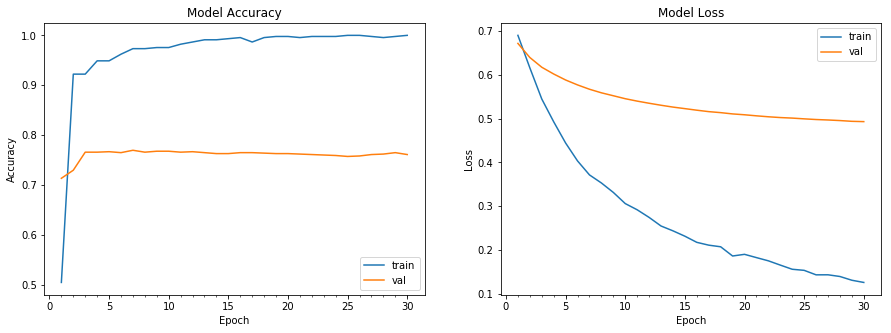

2018-12-11 22:57:23 ------------------------------------------------------------------------
2018-12-11 22:57:23 - Predictions:
500/500 [==============================] - 0s 164us/step


'[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,

2018-12-11 22:57:23 ------------------------------------------------------------------------
2018-12-11 22:57:23 - Test:


'[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,

2018-12-11 22:57:23 ------------------------------------------------------------------------
2018-12-11 22:57:23 - Performance:
500/500 [==============================] - 0s 47us/step
2018-12-11 22:57:23 - [score, accuracy]
2018-12-11 22:57:23 - [0.4693096518516541, 0.8140000009536743]
2018-12-11 22:57:23 ------------------------------------------------------------------------
2018-12-11 22:57:23 - Saving parameters: results/parameters/parameters_20181211225645_acc_0.814000.csv
2018-12-11 22:57:23 ------------------------------------------------------------------------
2018-12-11 22:57:23 - Saving predictions: results/predictions/predictions_20181211225645_acc_0.814000.csv
2018-12-11 22:57:23 - Done.
2018-12-11 22:57:23 ------------------------------------------------------------------------
2018-12-11 22:57:23 - STOP.
2018-12-11 22:57:23 ------------------------------------------------------------------------


In [16]:
# Cargamos argumentos de prueba
arguments = ['--model=1',
             '--max_features=6000',
             '--num_units=16',
             '--dropout=0.2',
             '--batch_size=200',             
             '--epochs=30',
             '--shuffle=batch',
             '--random_seed=10',
             '--verbose=1'
            ]

# Ejecutamos el procedimiento principal
main()

2018-12-11 22:58:08 ------------------------------------------------------------------------
2018-12-11 22:58:08 - START:
2018-12-11 22:58:08 ------------------------------------------------------------------------
2018-12-11 22:58:08 - Load and vectorize Data:
2018-12-11 22:58:09 - Training samples 1500 (1500), test_samples 500 (500)


/Users/mgualpa/anaconda3/envs/DataScience/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  sorted(inconsistent))


2018-12-11 22:58:42 - x_train_vec - type: <class 'numpy.ndarray'>, shape:(1500, 3877)
2018-12-11 22:58:42 - x_test_vec - type: <class 'numpy.ndarray'>, shape:(500, 3877)
total detected features 3877
vectorizer TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.97, max_features=None, min_df=0.01,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'there', 'me', "you're", 'has', 'under', 'a', "aren't", 'don', 'them', 'is', 'mustn', 'into', 'themselves', 'she', 'to', 'll', 'for', 'because', 'few', 'haven', 'your', 'with', 'herself', 'aren', 'have', 'such', 'they', 'am', 'and', 'own', "don't", 'ourselves', "hasn't", 'o', 'i', 'her',...', 'any', "you've", 're', 'won', "that'll", 'from', 'will', 'yours', 'him', 'very', "won't", 'once'},
        strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\

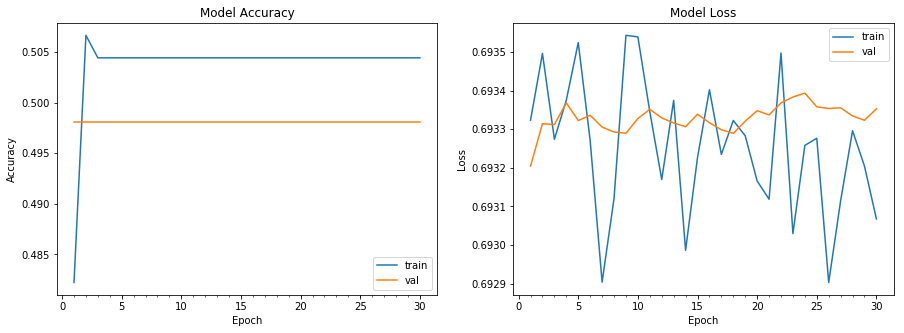

2018-12-11 23:10:53 ------------------------------------------------------------------------
2018-12-11 23:10:53 - Predictions:
500/500 [==============================] - 8s 15ms/step


'[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

2018-12-11 23:11:01 ------------------------------------------------------------------------
2018-12-11 23:11:01 - Test:


'[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,

2018-12-11 23:11:01 ------------------------------------------------------------------------
2018-12-11 23:11:01 - Performance:
500/500 [==============================] - 7s 14ms/step
2018-12-11 23:11:07 - [score, accuracy]
2018-12-11 23:11:07 - [0.6932886075973511, 0.5000000009536744]
2018-12-11 23:11:07 ------------------------------------------------------------------------
2018-12-11 23:11:07 - Saving parameters: results/parameters/parameters_20181211225808_acc_0.500000.csv
2018-12-11 23:11:08 ------------------------------------------------------------------------
2018-12-11 23:11:08 - Saving predictions: results/predictions/predictions_20181211225808_acc_0.500000.csv
2018-12-11 23:11:08 - Done.
2018-12-11 23:11:08 ------------------------------------------------------------------------
2018-12-11 23:11:08 - STOP.
2018-12-11 23:11:08 ------------------------------------------------------------------------


In [17]:
# Cargamos argumentos de prueba
arguments = ['--model=2',
             '--max_features=6000',
             '--num_units=16',
             '--dropout=0.2',
             '--batch_size=200',             
             '--epochs=30',
             '--shuffle=batch',
             '--random_seed=10',
             '--verbose=1'
            ]

# Ejecutamos el procedimiento principal
main()

2018-12-11 23:23:10 ------------------------------------------------------------------------
2018-12-11 23:23:10 - START:
2018-12-11 23:23:10 ------------------------------------------------------------------------
2018-12-11 23:23:10 - Load and vectorize Data:
2018-12-11 23:23:10 - Training samples 1500 (1500), test_samples 500 (500)


/Users/mgualpa/anaconda3/envs/DataScience/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  sorted(inconsistent))


2018-12-11 23:23:44 - x_train_vec - type: <class 'numpy.ndarray'>, shape:(1500, 3877)
2018-12-11 23:23:44 - x_test_vec - type: <class 'numpy.ndarray'>, shape:(500, 3877)
total detected features 3877
vectorizer TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.97, max_features=None, min_df=0.01,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words={'there', 'me', "you're", 'has', 'under', 'a', "aren't", 'don', 'them', 'is', 'mustn', 'into', 'themselves', 'she', 'to', 'll', 'for', 'because', 'few', 'haven', 'your', 'with', 'herself', 'aren', 'have', 'such', 'they', 'am', 'and', 'own', "don't", 'ourselves', "hasn't", 'o', 'i', 'her',...', 'any', "you've", 're', 'won', "that'll", 'from', 'will', 'yours', 'him', 'very', "won't", 'once'},
        strip_accents='ascii', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\

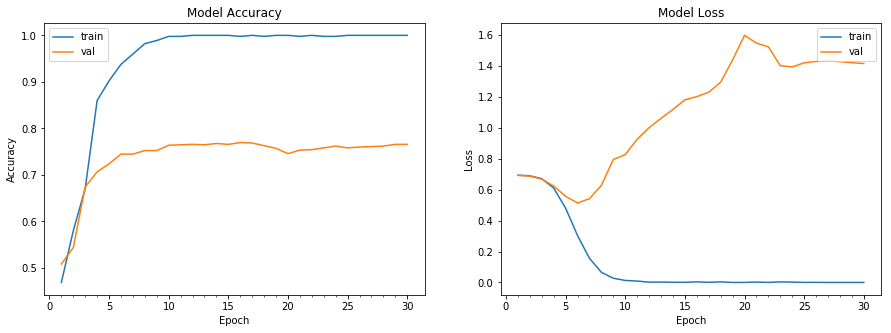

2018-12-11 23:23:55 ------------------------------------------------------------------------
2018-12-11 23:23:55 - Predictions:
500/500 [==============================] - 0s 518us/step


'[1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

2018-12-11 23:23:55 ------------------------------------------------------------------------
2018-12-11 23:23:55 - Test:


'[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,

2018-12-11 23:23:55 ------------------------------------------------------------------------
2018-12-11 23:23:55 - Performance:
500/500 [==============================] - 0s 223us/step
2018-12-11 23:23:56 - [score, accuracy]
2018-12-11 23:23:56 - [1.392213996887207, 0.7680000009536743]
2018-12-11 23:23:56 ------------------------------------------------------------------------
2018-12-11 23:23:56 - Saving parameters: results/parameters/parameters_20181211232310_acc_0.768000.csv
2018-12-11 23:23:56 ------------------------------------------------------------------------
2018-12-11 23:23:56 - Saving predictions: results/predictions/predictions_20181211232310_acc_0.768000.csv
2018-12-11 23:23:56 - Done.
2018-12-11 23:23:56 ------------------------------------------------------------------------
2018-12-11 23:23:56 - STOP.
2018-12-11 23:23:56 ------------------------------------------------------------------------


In [26]:
# Cargamos argumentos de prueba
arguments = ['--model=3',
             '--max_features=6000',
             '--num_units=16',
             '--dropout=0.2',
             '--batch_size=200',             
             '--epochs=30',
             '--shuffle=batch',
             '--random_seed=10',
             '--verbose=1'
            ]

# Ejecutamos el procedimiento principal
main()

# 3. Reporte 

__Responde al punto:__
_Reportar los hyperparámetros y resultados de todos los modelos entrenados. Para esto, pueden utilizar una notebook o un archivo (pdf|md). Dentro de este reporte tiene que describir:_

* _Hyperparámetros con los que procesaron el dataset: tamaño del vocabulario, normalizaciones, etc._
* _Las decisiones tomadas al construir cada modelo: regularización, dropout, número y tamaño de las capas, optimizador._
* _Proceso de entrenamiento: división del train/test, tamaño del batch, número de épocas, métricas de evaluación._ 
* _Seleccione los mejores hiperparámetros en función de su rendimiento. El proceso de entrenamiento debería ser el mismo
para todos los modelos._
* _(Punto estrella) Analizar si el clasificador está haciendo overfitting. Esto se puede determinar a partir del resultado del método fit._


## 3.1. Reporte de Hiperparámetros

Training samples 1500 (1500), test_samples 500 (500)
2018-12-08 17:36:49 - x_train_vec - type: <class 'numpy.ndarray'>, shape:(1500, 35393)
2018-12-08 17:36:50 - x_test_vec - type: <class 'numpy.ndarray'>, shape:(500, 22062)
                

## 3.2. Descripción de los Modelos Utilizados

Se describen a continuación los modelos utilizados para el trabajo.

### 3.2.1. Descripción del Modelo 1





### 3.2.2. Descripción del Modelo 2



### 3.2.3. Descripción del Modelo 3



## 3.3. Descripción de Proceso de Entrenamiento

## 3.4. Selección de los mejores hiperparámetros

## 3.5. Análisis sobre el Overfitting


# 4. Conclusiones

In [ ]:
0.8100000009536743



